# Notebook X: performing large searches for exoplanet (candidates) with TIKE

## Learning objectives

- rapidly access large amounts of TESS data on the cloud
- search for transits in large TESS data collections
- perform multithreading operations on TIKE

## Introduction
Studying exoplanet demographics (the frequency of different types of exoplanets) lets us tackle some of the biggest questions in exoplanet science: How do planets form? How do they evolve? Are there any exoplanets that are like the Earth? 

TIKE is an excellent resource for computing occurrence rates. There are other resources that explain TIKE elsewhere; we summarize some of the main TIKE benefits in this case below:

- your computations are performed "close" to MAST data, meaning that it's quicker to access lightcurves.
- you don't have to download data to your own computer, saving *storage* too.
- you don't have to use your own computational resources.
- in most cases, the scientific computing environments are already set up. you don't have to spend time wrangling with environments.


In this notebook, we'll take one of the first major steps to calculating occurrence rates: searching a large selection of lightcurves for exoplanets. Note: our abridged version may produce spurious planetary candidates! While we favor a concise narrative and rapid notebook execution time here, we'll note when applicable where a more robust approach should be taken for, e.g., a scientific publication.

# 1. Import packages, set constants

Before diving into planet-finding, we will import some necessary packages.

- `astropy` contains a number of utility functions for working with astronomical data.
- `astroquery` lets us easily query the astronomical databases that contain the TESS lightcurves.
- `numpy` is used for array manipulation.
- `matplotlib.pyplot` is used to display images and plot datasets.
- `tqdm` is a lightweight progress bar that we can use to track how long our calculations will take.
- `pandas` let us interact easily with CSV files that we'll be downliading.
- `os` and `concurrent` let us make informed choiced when multithreading.

In [10]:
!pip install astroquery==0.4.8.dev9474

  Using cached astroquery-0.4.8.dev9474-py3-none-any.whl.metadata (7.3 kB)
Using cached astroquery-0.4.8.dev9474-py3-none-any.whl (5.4 MB)
  Attempting uninstall: astroquery
    Found existing installation: astroquery 0.4.8.dev9321
    Uninstalling astroquery-0.4.8.dev9321:
      Successfully uninstalled astroquery-0.4.8.dev9321


In [1]:
import astroquery
astroquery.__version__

'0.4.8.dev9474'

In [2]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from astropy.timeseries import BoxLeastSquares


from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astroquery.exceptions import InvalidQueryError


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


import os
from concurrent.futures import ThreadPoolExecutor, as_completed

We will also *install* one package into our environment: the `batman` package. This tool will let us easily model exoplanet transits during our planet searches.

**Note**: this installation will not persist after restarting TIKE. See the [installation instructions](~/references/tike_content-ref/markdown/software-installed.md) to do a persistent installation.

In [3]:
!pip install batman-package

With our package installed, we can safely import it.

In [4]:
import batman

We'll now set a few physical constants and conversion factors so that we can use them later on.

In [5]:
G = const.G.si.value
days_to_seconds = (u.day).to(u.s)
r_earth_to_meters = (u.R_earth).to(u.m)
m_sun_kg = (u.M_sun).to(u.kg)
r_sun_m = (u.R_sun).to(u.m)

We'll also make sure that we retrieve cloud files from AWS, making our data access stage much faster.

In [6]:
# Important: ensure files are retrieved from AWS 
Observations.enable_cloud_dataset(provider='AWS')

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


# 2. Find stars

Generally, the first step to finding planets is figuring out which host stars you want to search for orbiting planets. In this study, we want to find the occurrence of hot Jupiters around Sun-like stars. We'll make some cuts so that we're looking for bright, high-gravity, solar-mass stars:

- *bright*: TESS was designed to look for transits around bright, nearby stars. These stars' TESS data will have high signal to noise ratios, so we have better chances of finding planetary signals in them.
- *high-gravity*: particularly low-gravity stars tend to be evolved off the stellar main-sequence, and therefore not very Sun-like.
- *solar-mass*: solar-mass stars on the stellar main sequence tend to be quite solar.

To find these stars, we'll query the TESS Candidate Target List (CTL) — a list of stars pre-selected by the TESS team to be likely good targets for transit detection (e.g., bright, low flux contamination).

In [7]:
# this cell will take ~30 seconds to run
catalog_data = Catalogs.query_criteria(catalog="Ctl",
                                       Tmag=[0, 10.5], # remember, lower magnitudes are brighter than higher ones!
                                      logg=[4.1,400], # solar logg ~ 4.4
                                      mass=[0.8, 1.05]) # these masses are in solar radii

Let's take a look at this catalog data.

In [8]:
catalog_data

ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str10,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str4,str7,float64,float64,str7,float64,float64,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str9,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str8,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,str10
83940523,20190415,--,2267-01192-1,621-000009,00000410+3411189,--,J000003.89+341118.1,2875125810310195712,48962970,--,STAR,tmgaia2,0.0169976360306548,34.1885450373917,tmgaia2,-224.498,0.24663,-54.9296,0.155716,gaia2,19.0591,0.212669,gaia2,110.970220773112,-27.4871944672489,15.1354693242748,31.0276744291869,9.145,0.028,8.493,0.002,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.249,0.017,6.94,0.016,6.885,0.017,AAA-111-111-000-0-0,nan,6.851,0.062,6.871,0.019,6.883,0.016,6.824,0.085,8.33714,0.00027,7.8954,0.006,gbprp,gaia2,5704.0,126.167,4.44826,0.0772625,nan,nan,0.998172,0.0498392,1.02,0.123428,1.02562,0.217127,DWARF,0.9502178,0.03231535,52.401,0.58845,0.0,0.0,90,0.00158335292,--,--,0.00585454023552081,0.0,0.0,--,0.100151,0.146704,0.0498518,0.0498266,0.20157,0.232683,0.0784076,0.0761174,0.0362655,0.0283652,0.582,0.5949,bj2018,114.575,137.759,dered0,8.69435,0.000975,7.85136,0.00121,1,--,tycho2v3,tycho2b3,planetcandidate,4.00141383686189,2.41580491918867,0.0158291195166365,34.1883085404878,0.125382565601784,0.10323808392345,1,0,833
118005970,20190415,--,1735-00930-1,596-000142,00030313+2901556,1237663307455004777,J000303.12+290155.2,2854992481095306752,47911378,--,STAR,tmgaia2,0.763038317145479,29.0321173400183,tmgaia2,-12.5026,0.0689185,-37.0456,0.0320888,gaia2,8.55616,0.0487874,gaia2,110.362199420804,-32.6558834136927,13.1170981454118,26.1435853405611,11.964,0.224,11.466,0.015,14.8854,0.00715932,11.7441,0.000664854,10.9885,0.000551802,10.7408,0.00065727,11.0516,0.00217147,9.603,0.023,9.193,0.021,9.101,0.018,AAA-222-111-000-0-0,nan,9.04,0.023,9.073,0.02,9.005,0.031,8.383,0.223,10.9284,0.000526,10.3891,0.006,rered,gaia2,5203.0,130.632,4.52689,0.0856953,nan,nan,0.8493,0.0498492,0.885,0.111835,1.44464,0.349108,DWARF,0.476246566,0.0156704,116.487,0.667,0.0167619,0.009038565,60,0.00107958447,--,--,0.00207309863826472,0.00724383,0.0108333,panstarrs,0.0990487,0.124622,0.0562578,0.0434407,0.318475,0.37974,0.108065,0.0633256,0.015635,0.0157058,0.664,0.67,bj2018,119.297,141.967,dered,11.3888,0.000798,10.3442,0.000652,1,--,tycho2v3,tycho2b3,planetcandidate,1.10420925200251,0.497755073291291,0.762976750525541,29.0319578381425,0.0406243496299374,0.0194121021597093,1,0,18347
11800742

This is a pretty long table, totaling 53056 stars, with many columns of information about each star.

To get a better sense of the data products we'll be working with, let's access a single lightcurve associated with one of these stars.

In [10]:
TESS_table

['s3://stpubdata/tess/public/tid/s0057/0000/0001/1800/7429/tess2022273165103-s0057-0000000118007429-0245-s_lc.fits',
 's3://stpubdata/tess/public/tid/s0057/0000/0001/1800/7429/tess2022273165103-s0057-0000000118007429-0245-s_tp.fits']

In [28]:
# download a single star from this catalog to inspect the data type we're working with.
TESS_table = Observations.query_criteria(target_name=catalog_data['ID'][2]
                                                 , obs_collection="TESS"
                                                 , dataproduct_type='timeseries'
                                                 )
# get data products
data_products = Observations.get_product_list(TESS_table) 

# # filter for light curve data only
# filtered = Observations.filter_products(data_products, productType="SCIENCE"
#                                         , productSubGroupDesciption = "LC")

lc_prod = Observations.filter_products(data_products  , productType="SCIENCE"
                                              , productSubGroupDescription = "LC")

# Get the cloud uri for these files
lc_uri = Observations.get_cloud_uris(lc_prod)[0]

#open the lc file
lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})

In [29]:
lc_prod

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str10,str47,str18,str1,str73,str7,str28,str2,str1,str4,str20,str3,str55,int64,str9,str6,int64,str4
101298272,TESS,timeseries,tess2022273165103-s0057-0000000118007429-0245-s,Light curves,S,mast:TESS/product/tess2022273165103-s0057-0000000118007429-0245-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.77-20221025,N/A,tess2022273165103-s0057-0000000118007429-0245-s_lc.fits,2102400,101298272,PUBLIC,3,TESS


Great! This file is now loaded as `lc_fits`. Now, let's examine the columns available to us in this lightcurve.

In [22]:
lc = lc_fits[1].data
lc.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

There are two flux columns: SAP flux and PDCSAP flux. The SAP flux is closer to raw TESS data. The PDCSAP_FLUX is derived from SAP flux, but it's been cleaned of longer-term trends.

Let's plot both types of flux to get a sense of their differences.

Text(0.5, 0, 'TIME  (BJD-2457000)')

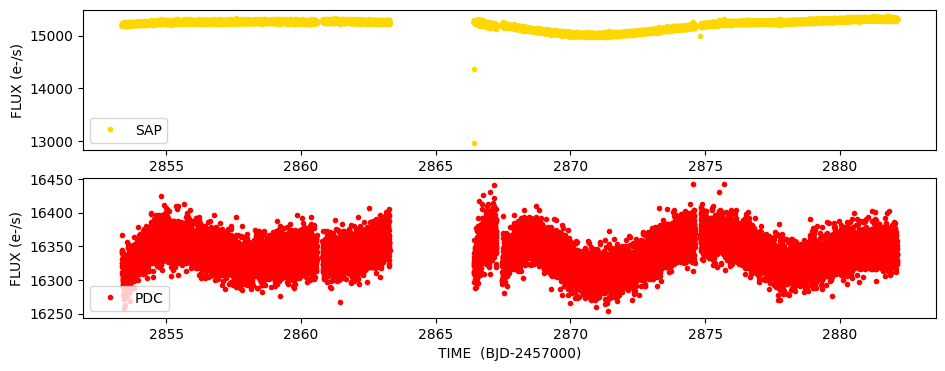

In [23]:
sapflux = lc['SAP_FLUX']
pdcflux = lc['PDCSAP_FLUX']
time_lc = lc['TIME']

fig = plt.figure(figsize = (11,4))

fig.add_subplot(211)
plt.plot(time_lc, sapflux,'.', label = 'SAP', color = "gold")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")

fig.add_subplot(212)
plt.plot(time_lc, pdcflux,'.', label = 'PDC', color = "red")
plt.legend(loc = 'lower left')
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

This definitely looks like a TESS lightcurve! The PDC data, as expected, are smoother and seem more evenly distributed about a median value.

# Next: aggregate all the lightcurves!

Now we know how to access a single lightcurve. To calculate our occurrence rates, we'll need to download lightcurves from many stars. 

The neatest way to do this is to write a function that accesses TESS lightcurves, then loop over that function for all the stars we want to query. Along the way, we'll incorporate a few tricks to speed things up.

Instead of, e.g., saving the data as files, it's more efficient to keep all of this data in RAM as we go. A neat way to do this is to define a class for our data, fetch the data with a method of that class, then assign the data to an attribute of that class. This object-oriented approach avoids extra input/output (I/O) time and maintains clean code design.

In [39]:
class LightcurveData:
    def __init__(self, catalog_id):
        """
        Initializes the instance.
        """
        self.catalog_id = catalog_id # assign catalog ID to the object

    def fetch_and_save_data(self):
        """
        Accesses and saves data from a TESS target.
    
        Inputs
        ------
            :catalog_id: (int) TESS Input Catalog (TIC) ID.
        """
        TESS_table = Observations.query_criteria(target_name=self.catalog_id
                                                 , obs_collection="TESS"
                                                 , dataproduct_type='timeseries'
                                                 ) 
        try:
            data_products = Observations.get_product_list(TESS_table) 
        except InvalidQueryError:
            self.pdcflux = np.nan
            self.pdcflux_err = np.nan
            self.time_lc = np.nan
            return
            
            
        # Keep only the science products
        filtered = Observations.filter_products(data_products
                                                , productType="SCIENCE")
        
        # filter
        lc_prod = Observations.filter_products(data_products  
                                              , productSubGroupDescription = "LC")
        
        # Get the cloud uris for these files
        lc_uri = Observations.get_cloud_uris(lc_prod)[0]
    
        # open the lc file
        lc_fits = fits.open(lc_uri, use_fsspec=True, fsspec_kwargs={"anon": True})
        
        # assign the data to this instance 
        lc = lc_fits[1].data
        sapflux = lc['SAP_FLUX'] #SAP flux column
        self.pdcflux = lc['PDCSAP_FLUX'] #PDCSAP flux column
        self.pdcflux_err = lc['PDCSAP_FLUX_ERR'] # flux error column
        self.time_lc = lc['TIME'] #time column

Let's test this method out on a single star.

In [43]:
lightcurvedata = LightcurveData(catalog_data['ID'][2])
lightcurvedata.fetch_and_save_data()

Let's check that this function worked correctly by checking that the method performed as expected.

In [44]:
lightcurvedata.time_lc, lightcurvedata.pdcflux_err

(array([2853.35443832, 2853.35582723, 2853.35721613, ..., 2882.11645363,
        2882.11784247, 2882.11923131], dtype='>f8'),
 array([      nan,       nan,       nan, ..., 16.238762, 16.231731,
        16.240055], dtype='>f4'))

Great! Our data has been downloaded and assigned as an attribute to an object.

Now, we want to *parallelize* our computation. What this means is we want to access multiple lightcurve files simultaneously.

We'll use this with the Python [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) package to perform multithreading. Multithreading is a very [rich and complex subject](https://www.geeksforgeeks.org/multithreading-python-set-1/) — for our purposes, we can just think of it as splitting up our machine into different sections that each perform a separate task. Because our option is largely limited by remote server wait time, multithreading is a good parallelization choice.

Users typically have acess to 4 cores on TIKE, as of this document's last update. We can check the exact number below.

In [45]:
os.cpu_count() 

4

Now for a short function that will create an object for a catalog ID, download the data, and return the *object*.

We'll have this function return both the TIC ID and the object itself so that it can be sorted even if we work through our catalog asynchronously.

In [46]:
def return_object(catalog_id):
    lightcurvedata = LightcurveData(catalog_id)
    lightcurvedata.fetch_and_save_data()
    return catalog_id, lightcurvedata

In [47]:
# Use ThreadPoolExecutor to download files in parallel
total_tasks = len(catalog_data['ID'][::100])
progress_bar = tqdm(total=total_tasks, position=0, leave=True)

max_workers = 5  # Adjust this based on your system's capabilities

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(return_object, catalog_id) for catalog_id in catalog_data['ID'][::100]]
    for future in as_completed(futures):
        progress_bar.update(1)
    

# now store all the data in a list
lightcurve_objects = {}
for future in futures:
    catalog_id, lightcurvedata = future.result()
    lightcurve_objects[catalog_id] = lightcurvedata

100%|█████████▉| 529/531 [01:25<00:00,  5.10it/s]

We can access each object now from the `lightcurve_objects` dictionary. Let's check!

In [48]:
lightcurve_objects[catalog_data['ID'][0]].time_lc

array([1764.68382866, 1764.68521756, 1764.68660645, ..., 1789.69585124,
       1789.69724009, 1789.69862894], dtype='>f8')

Nice! This our list of of observation times for this target star.

# Next: search the lightcurves for planets.
We now have our processed data products. The next step is to search them for planets!

One of the standard ways to do this is with the [Box-Least Squares algorithm](https://arxiv.org/abs/astro-ph/0206099). This approach takes advantage of the facts that 1) planetary transits are expected to be periodic, and 2) transits are more or less shaped like boxes (excluding effects like limb-darkening). Loosely, the algorithm works similarly to the Lomb-Scargle periodogram, with the key difference that the signal being tested is a box car, instead of a sine wave.

Let's load in a light curve and test out the algorithm.

In [69]:
time, flux, flux_err  = lightcurve_objects[catalog_data['ID'][300]].time_lc,  \
                        lightcurve_objects[catalog_data['ID'][300]].pdcflux,  \
                        lightcurve_objects[catalog_data['ID'][300]].pdcflux_err

time = time[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux)]
flux = flux[~np.isnan(flux)]
model = BoxLeastSquares(time, flux, flux_err)

For this example, we'll search for planets with periods between 0.5 and 10 days. The lower limit is physical: planets can only have periods that are so short before their orbits are unstable. The upper limit is statistical: [Nyquist sampling](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) dictates that you can only detect periodic signals with frequencies at most *half* your observational baseline. That is, you need to be able to detect your signal twice in a dataset in order to measure its period. Because TESS sectors are generally 27 days long, we'll set our upper limit to 13 days. We'll test 1000 trial periods for the purposes of this exploratory notebook.

In [70]:
lower_limit = 0.5 #days
upper_limit = 13 # days
n_periods_tested = 1000
periods = np.linspace(lower_limit, upper_limit, n_periods_tested)  # in units of days.

To search for the planets, we will need to specify a transit duration. At first, this may seem like a daunting task — will we have to provide another axis to our search?

To keep things computationally feasible for this notebook, let's appeal to the original goal: finding hot Jupiters orbiting Sun-like stars. Because we're searching for a specific planet type (with a certain orbital period range) orbiting a certain type of star, there should be an expected transit duration for our search. Let's calculate what that duration is.

First, we'lll need to calculate the semimajor axis of the planet from its period and the masses in the system. Luckily, we can do this using Kepler's Third Law.

In [71]:
def calc_a_from_period(period, planet_mass, stellar_mass):
    """

    Given the period, uses Kepler's Third Law to calculate the semimajor axis in meters.

    Inputs
    -----
        :period: orbital period of planet (s)
        :planet_mass: mass of planet (kg)
        :stellar_mass: mass of star (kg)

    Outputs
    ------
        :a: semimajor axis(meters)
    """
    total_mass = planet_mass + stellar_mass
    a_cubed = (const.G.si.value * total_mass * period**2) / (4 * np.pi**2)
    a = a_cubed**(1/3)
    return a

Now that we have the semimajor axis, we can move on to the transit duration. Assuming a circular orbit, the transit duration is (Seager & Mallén-Ornelas 2003):

$$T_{\rm dur} =\frac{P}{\pi} \arcsin\bigg{(}\frac{\sqrt{1 - a^2/R_{\star}^2 \cos^2(i)}}{a^2/R_{\star}^2\sin(i)}\bigg{)},$$

where $P$ is the orbital period, $a$ is the semimajor axis, $R_{\star}$ is the orbital inclination, and $i$ is the orbital inclination.

What do we know? We have the mass of the planet and the star, and the orbital period is about a day. From Kepler's third law we can then calculate the semimajor axis. 

Let's code this up!

In [72]:
def calc_t_dur(P, a, rstar, i):
    """
    Calculates the transit duration, in seconds, of a planet.

    Inputs
    ------
        :P: the orbital period of the planet, in seconds.
        :a: the semimajor axis of the planet, in meters.
        :rstar: the radius of the star, in meters.
        :i: the inclincation of the planet, in radians. an inclination of 0 is face-on (non-transiting); an inclination of pi/2 is perfectly transiting.
    """
    a_r_2 = (a/rstar)**2
    return (P / np.pi) * np.arcsin(np.sqrt(1 - a_r_2 * np.square(np.cos(i))) / (a_r_2 * np.sin(i)))
    

Great. Now, let's establish some representative values for a Hot Jupiter orbiting a Sun-like star and calculate its transit duration.

In [73]:
period = (3 * u.day).si.value # 1 day orbital period, expressed in seconds
planet_mass = (1 * u.M_jup).si.value # jupiter mass
stellar_mass = (1 * u.M_sun).si.value # solar mass
stellar_radius = (1 * u.R_sun).si.value # solar radius
inclination  = np.pi/2 # transiting across the stellar equator

a = calc_a_from_period(period, planet_mass, stellar_mass)
t_dur = calc_t_dur(period, a, stellar_radius, inclination)

(t_dur * u.s).to(u.hour), (t_dur * u.s).to(u.day)

(<Quantity 0.29891527 h>, <Quantity 0.0124548 d>)

Now, let's express this transit duration in days and find our planets.

In [74]:
t_dur = (t_dur * u.s).to(u.day).value
t_dur

0.012454802805972288

In [75]:
results = model.power(periods, t_dur)  # The second argument is the duration of the transit (in days)

We can access the best-fitting period from our planet search with the below cell.

In [76]:
best_period = results.period[np.argmax(results.power)]
print("Best-fit period:", best_period)

Best-fit period: 11.986486486486488


Now let's plot up the signal-to-noise of the tested planetary signals at all tested periods, paying special attention to the best-fitting period.

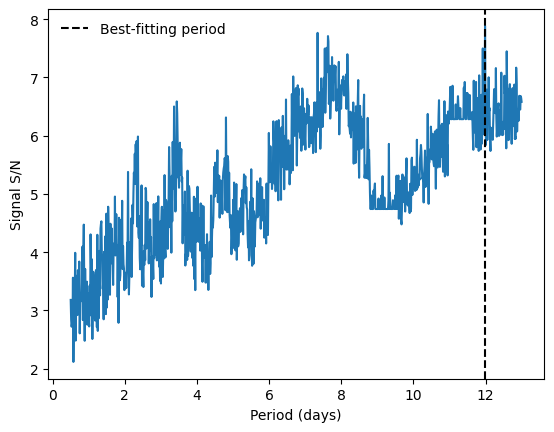

In [77]:
plt.plot(results.period, results.depth_snr)
plt.axvline(best_period, color='black', linestyle='--', label='Best-fitting period')
plt.xlabel('Period (days)')
plt.ylabel('Signal S/N')
plt.legend(frameon=False)

Awesome! We see that there is a clear peak in the signal-to-noise function. That is, we found a potential planetary signal in our data.

Next, let's wrap this code in a function and apply it to all the selected planets. First, let's write a function that just runs the BLS algorithm and returns its outputs for a given time, flux, and flux error.

In [78]:
def do_bls(time, flux, flux_err):
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, 0.1)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    return results, stats

Next, we'll add a simple *inversion test*. This step flips the lightcurve and performs the same BLS search. The idea is that a true planetary signal will not return significant BLS results after being inverted, whereas a false positive (like a variable star producing a sinusoidal lightcurve) *will* produce a signal after being inverted.

In [79]:
def do_inversion_test(time, flux, flux_err):
    inverted_flux = -1 * flux + 2* np.mean(flux)
    results, stats = do_bls(time, inverted_flux, flux_err)
    return results, stats

Now we can wrap this all up in a function to find planets based on their TICIDs.

In [86]:
def find_planet(ticid):
    """
    This is our main function to find a planet. We basically perform the box-least squares algorithm, 
    then do a simple inversion test.

    todo: make this searchable by ticid.
    """
    lightcurve_object = lightcurve_objects[ticid]
    time, flux, flux_err  = lightcurve_object.time_lc, lightcurve_object.pdcflux, lightcurve_object.pdcflux_err

    # time is just a nan if the download did not proceed correctly.
    if isinstance(time, float):
        return np.nan


    time = time[~np.isnan(flux)]
    flux_err = flux_err[~np.isnan(flux)]
    flux = flux[~np.isnan(flux)]
    model = BoxLeastSquares(time, flux, flux_err)
    results = model.power(periods, t_dur)  # The second argument is the duration of the transit (in days)
    max_power = np.argmax(results.power)
    stats = model.compute_stats(results.period[max_power],
                                results.duration[max_power],
                                results.transit_time[max_power])

    
    # do the inversion test here. if we invert it and find a "transit," that is not good.
    if len(stats['transit_times']) >= 2 and results.depth_snr[max_power] >= 10:

        # test for variability
        inverted_results, inverted_stats = do_inversion_test(time, flux, flux_err)
        if len(inverted_stats['transit_times']) < 2 or inverted_results.depth_snr[max_power] < 10:
            return True

    # todo: The harmonic_delta_log_likelihood is the difference in log likelihood between a sinusoidal model and the transit model. If harmonic_delta_log_likelihood is greater than zero, the sinusoidal model is preferred.

            
    return False

        

With our function ready to go, we can apply it to all the planet's we'd like now.

In [104]:
found_planets = {}
for catalog_id in tqdm(catalog_data['ID'][::100], position=0):
    found_planets[catalog_id] = find_planet(catalog_id)

100%|██████████| 531/531 [01:52<00:00,  4.72it/s]


Great! Let's quickly see how many planets our simple pipeline found.

In [105]:
found_planets_values = np.array(list(found_planets.values()))
found_planets_values = found_planets_values[np.isfinite(found_planets_values)]


n_found_planets = np.sum(found_planets_values)
n_found_planets

7.0

The simplest way to calculate occurrence rates is to divide the number of planets found by the number of stars searched. Let's go ahead and try that out.

In [106]:
n_successfully_searched = len(found_planets_values)
n_found_planets/n_successfully_searched

0.01907356948228883

This number is higher than the expected hot Jupiter occurrence rate (about 0.6% around G stars; [Beleznay & Kunimoto 2022](https://academic.oup.com/mnras/article/516/1/75/6654884)).

The reason for this is simple: we must have a lot of false positives! More advanced planet-finding and occurrence rate pipelines take multiple additional factors into consideration:

- some of the planet signals are astrophysical (e.g., eclipsing binary) or instrumental (e.g., the Kepler "rolling bands") false positives.
- we are not sensitive to planets orbiting in all configurations via the transit method (i.e., most planets do not transit).
- our pipeline is equally sensitive to all signal sizes, e.g. smaller planets around bigger stars.

Let's take a quick look at one of our targets' lightcurves to assess whether it might be a false positive.

In [134]:
# make a list of just the names of the targets that may have orbiting planets
found_planets_names = [i for i in found_planets.keys() if found_planets[i]==True]
found_planets_names

['68038123',
 '259469395',
 '155948486',
 '56812239',
 '205591831',
 '290596728',
 '266980320']

Text(0.5, 0, 'TIME  (BJD-2457000)')

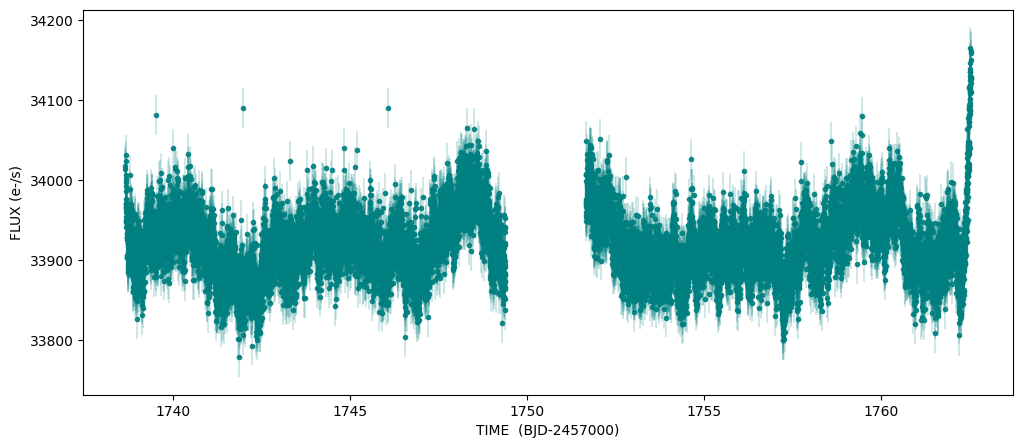

In [135]:
# now, plot up the lightcurve.
plt.figure(figsize=(12,5))

name = found_planets_names[2]
obj = lightcurve_objects[name]

plt.errorbar(obj.time_lc, obj.pdcflux, yerr=obj.pdcflux_err, fmt='.', color='teal', alpha=0.9, lw=0.3)
# fold on the period
plt.ylabel("FLUX (e-/s)")
plt.xlabel('TIME  (BJD-2457000)')

The above lightcurve indeed looks a bit messy. There's a decent chance that there is not a planetary signal within the data. So, a publication-ready planet detection / occurrence rate pipeline would certainly need to take more steps to flag these false positives.

## About this notebook


**Last updated:** Nov 2024

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 